In [1]:
import os
from braindecode.datasets.bbci import BBCIDataset
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib
matplotlib.use('Agg')
from BCI_IV_2a_loader import BCI_IV_2a
from collections import OrderedDict
from braindecode.mne_ext.signalproc import mne_apply, resample_cnt
from braindecode.datautil.splitters import split_into_two_sets
from braindecode.datautil.signalproc import bandpass_cnt, exponential_running_standardize, highpass_cnt
from braindecode.datautil.trial_segment import create_signal_target_from_raw_mne
from sklearn.model_selection import train_test_split
from moabb.datasets import Cho2017, BNCI2014004
from moabb.paradigms import (LeftRightImagery, MotorImagery,
                             FilterBankMotorImagery)
from data.Bloomberg.bloomberg_preproc import get_bloomberg
from data.HumanActivity.human_activity_preproc import get_human_activity
from data.Opportunity.sliding_window import sliding_window
from sklearn import preprocessing
import pickle
import globals
import logging
import numpy as np
import pandas as pd

log = logging.getLogger(__name__)
log.setLevel('DEBUG')


def get_bci_iv_2a_train_val_test(data_folder,subject_id, low_cut_hz):
    ival = [-500, 4000]  # this is the window around the event from which we will take data to feed to the classifier
    high_cut_hz = 38  # cut off parts of signal higher than 38 hz
    factor_new = 1e-3  # ??? has to do with exponential running standardize
    init_block_size = 1000  # ???

    train_filename = 'A{:02d}T.gdf'.format(subject_id)
    test_filename = 'A{:02d}E.gdf'.format(subject_id)
    train_filepath = os.path.join(data_folder, train_filename)
    test_filepath = os.path.join(data_folder, test_filename)
    train_label_filepath = train_filepath.replace('.gdf', '.mat')
    test_label_filepath = test_filepath.replace('.gdf', '.mat')

    train_loader = BCI_IV_2a(train_filepath, train_label_filepath)
    test_loader = BCI_IV_2a(test_filepath, test_label_filepath)
    train_cnt = train_loader.load()
    test_cnt = test_loader.load()

    train_cnt = train_cnt.drop_channels(['STI 014', 'EOG-left',
                                         'EOG-central', 'EOG-right'])
    assert len(train_cnt.ch_names) == 22

    # convert measurements to millivolt
    train_cnt = mne_apply(lambda a: a * 1e6, train_cnt)
    train_cnt = mne_apply(  # signal processing procedure that I don't understand
        lambda a: bandpass_cnt(a, low_cut_hz, high_cut_hz, train_cnt.info['sfreq'],
                               filt_order=3,
                               axis=1), train_cnt)
    train_cnt = mne_apply(  # signal processing procedure that I don't understand
        lambda a: exponential_running_standardize(a.T, factor_new=factor_new,
                                                  init_block_size=init_block_size,
                                                  eps=1e-4).T,
        train_cnt)

    test_cnt = test_cnt.drop_channels(['STI 014', 'EOG-left',
                                       'EOG-central', 'EOG-right'])
    assert len(test_cnt.ch_names) == 22

    # convert measurements to millivolt
    test_cnt = mne_apply(lambda a: a * 1e6, test_cnt)
    test_cnt = mne_apply(
        lambda a: bandpass_cnt(a, low_cut_hz, high_cut_hz, test_cnt.info['sfreq'],
                               filt_order=3,
                               axis=1), test_cnt)
    test_cnt = mne_apply(
        lambda a: exponential_running_standardize(a.T, factor_new=factor_new,
                                                  init_block_size=init_block_size,
                                                  eps=1e-4).T,
        test_cnt)

    marker_def = OrderedDict([('Left Hand', [1]), ('Right Hand', [2],),
                              ('Foot', [3]), ('Tongue', [4])])

    train_set = create_signal_target_from_raw_mne(train_cnt, marker_def, ival)
    test_set = create_signal_target_from_raw_mne(test_cnt, marker_def, ival)
    train_set, valid_set = split_into_two_sets(
        train_set, first_set_fraction=1 - 0.2)

    return train_set, valid_set, test_set

c:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from BCI_IV_2a_experiment import parse_args, get_configurations
import globals
from braindecode.torch_ext.util import np_to_var
from visualiazation.src.misc_functions import create_mne
import matplotlib.pyplot as plt
import os.path as op
import mne

train_set, val_set, test_set = get_bci_iv_2a_train_val_test('data/BCI_IV/', 1, 0)

Extracting EDF parameters from data/BCI_IV/A01T.gdf...
GDF file detected


c:\anaconda\lib\site-packages\mne\io\edf\edf.py:1028: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
C:\Users\Elad Rapaport\PycharmProjects\BCI_benchmarks\BCI_IV_2a_loader.py:18: RuntimeWarning: Overlapping events detected. Use find_edf_events for the original events.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')


Overlapping events detected. Use find_edf_events for the original events.
Setting channel info structure...


C:\Users\Elad Rapaport\PycharmProjects\BCI_benchmarks\BCI_IV_2a_loader.py:18: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')


Interpolating stim channel. Events may jitter.
Creating raw.info structure...


C:\Users\Elad Rapaport\PycharmProjects\BCI_benchmarks\BCI_IV_2a_loader.py:18: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')


Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...
Extracting EDF parameters from data/BCI_IV/A01E.gdf...
GDF file detected


c:\anaconda\lib\site-packages\mne\io\edf\edf.py:1028: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
C:\Users\Elad Rapaport\PycharmProjects\BCI_benchmarks\BCI_IV_2a_loader.py:18: RuntimeWarning: Overlapping events detected. Use find_edf_events for the original events.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')


Overlapping events detected. Use find_edf_events for the original events.
Setting channel info structure...


C:\Users\Elad Rapaport\PycharmProjects\BCI_benchmarks\BCI_IV_2a_loader.py:18: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')


Interpolating stim channel. Events may jitter.
Creating raw.info structure...


C:\Users\Elad Rapaport\PycharmProjects\BCI_benchmarks\BCI_IV_2a_loader.py:18: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')


Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
Reading 0 ... 686999  =      0.000 ...  2747.996 secs...


In [3]:
def create_all_spectrograms(data, im_size=256):
    for j, channel in enumerate(data[5:6]):
        channel *= 1000
        fig = plt.figure(frameon=False)
        fig.set_size_inches((im_size - 10) / 96, (im_size - 10) / 96)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.plot(list(range(len(channel))), channel)
        ax2.specgram(channel, NFFT=256, Fs=250, noverlap=255)
        fig.canvas.draw()
        plt.show()
        plt.close(fig)

<Figure size 184.5x184.5 with 0 Axes>

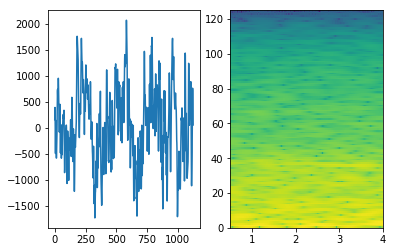

In [4]:
%matplotlib inline
create_all_spectrograms(train_set.X[0].squeeze())
# globals.set_config({'DEFAULT':{'exp_name': 'test'}, 'test':{}})
# globals.set('dataset', 'BCI_IV_2a')
# globals.set('valid_set_fraction', 0.2)
# train_set, val_set, test_set = get_train_val_test('data/', 1, 0)
# to_mne = np_to_var(train_set.X[0])
# mne_raw = create_mne(to_mne)
# mne_raw.plot()

# data_path = op.join(mne.datasets.sample.data_path(), 'MEG', 'sample')
# raw = mne.io.read_raw_fif(op.join(data_path, 'sample_audvis_raw.fif'),                      preload=True)
# raw.set_eeg_reference('average', projection=True)  # set EEG average reference
# raw.plot(block=True, lowpass=40)


c:\anaconda\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


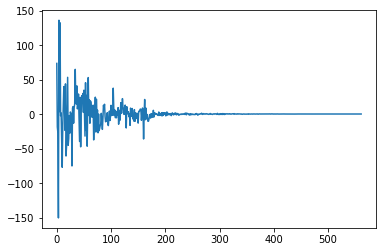

In [96]:
channel_data = train_set.X[0].squeeze()[0] 
freqs = np.fft.fft(channel_data)[:int(len(channel_data)/2)]
plt.plot([i for i in range(int(len(channel_data)/2))], freqs)

[-1.        -0.9989995 -0.997999  ...  0.997999   0.9989995  1.       ]
[[ 2.16941870e+00  2.25398468e+00  2.33774902e+00 ...  1.99800242e+00
   2.08408116e+00  2.16941870e+00]
 [ 5.74025149e+00  6.59951094e+00  7.43269909e+00 ...  3.95718621e+00
   4.85831522e+00  5.74025149e+00]
 [-1.10218212e-14 -3.14264671e-01 -6.28218891e-01 ...  6.28218891e-01
   3.14264671e-01  4.89982516e-14]
 [ 5.00000000e+00  4.97778763e+00  4.91134789e+00 ...  4.91134789e+00
   4.97778763e+00  5.00000000e+00]
 [-4.94974747e+00 -3.75013735e+00 -2.36971629e+00 ... -6.58668693e+00
  -5.91070807e+00 -4.94974747e+00]]
[ 7.95992271  9.76688123 11.68386082 ...  4.90806848  6.32374061
  7.95992271]
[0.000e+00 5.000e-04 1.000e-03 ... 9.985e-01 9.990e-01 9.995e-01]


c:\anaconda\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


[  0.    0.5   1.  ... 499.  499.5 500. ]


c:\anaconda\lib\site-packages\ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


[-159.46150621 -159.46150621 -159.46150621 ... -159.46150621 -159.46150621
 -159.46150621]
2000


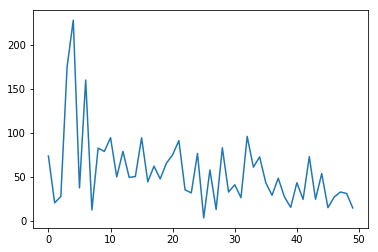

In [98]:
srate = 1000;
frex = [3,10,5,15,35]
amplit = [5,15,10,5,7];
phases = [np.pi/7,np.pi/8,np.pi,np.pi/2,-np.pi/4]
time = np.linspace(-1, 1, 2000)
print(time)
sine_waves = np.zeros((len(frex),len(time)))
for fi in range(len(frex)):
    sine_waves[fi,:] = amplit[fi] * np.sin(2*np.pi*time*frex[fi] + phases[fi]);
print(sine_waves)
signal = np.sum(sine_waves, axis=0);
print(signal)
N = len(signal)
fourierCoefs = np.zeros(N); 
fourierTime = np.array([i for i in range(N)]) / N
print(fourierTime)
nyquist = srate/2; 
frequencies = np.linspace(0,nyquist,(N/2)+1);
print(frequencies)

for fi in range(1,N+1):
    fourierSine = np.multiply(np.exp(-1j*2*np.pi*(fi-1)),fourierTime);
    
    fourierCoefs[fi-1] = np.sum(fourierSine * signal)
    
print(fourierCoefs)

def DFT(x):
    """
    Compute the discrete Fourier Transform of the 1D array x
    :param x: (array)
    """

    N = x.size
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    return np.dot(e, x)

# plt.plot(frequencies,abs(fourierCoefs[:len(frequencies)])*2,'*-')
print(len(DFT(signal)))
plt.plot([i for i in range(int(len(channel_data)))][:50], np.abs(DFT(channel_data))[:50])
# plt.plot([i for i in range(int(len(channel_data)))], fourierCoefs)

In [87]:
# x=np.exp(-1j*2*np.pi*(5-1)) * fourierTime
# print(len(x))
# print(len(signal))
# print(x[1200] * signal[1200])
# print(x[1200])
# print(signal[1200])
x=np.exp(-1j*2*np.pi*(5-1))
print(x)
fourierTime * x
signal[1999]

(1+9.797174393178826e-16j)


7.959922712758233